In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from trojan_defender import set_root_folder
from trojan_defender import datasets, plot, evaluate, train, models, log
from trojan_defender.poison import patch, poison

In [21]:
logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = (10, 10)
set_root_folder('/Users/Edu/Desktop')

In [4]:
dataset = datasets.load_preprocessed_mnist()

In [5]:
dataset.x_train.shape

(60000, 28, 28, 1)

In [6]:
dataset.y_train.shape

(60000, 10)

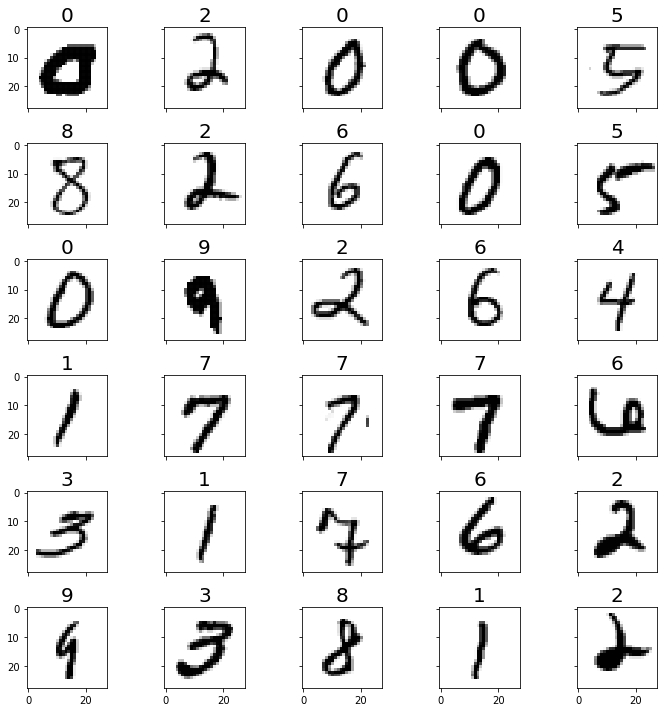

In [7]:
plot.grid(dataset.x_train, dataset.y_train_cat)

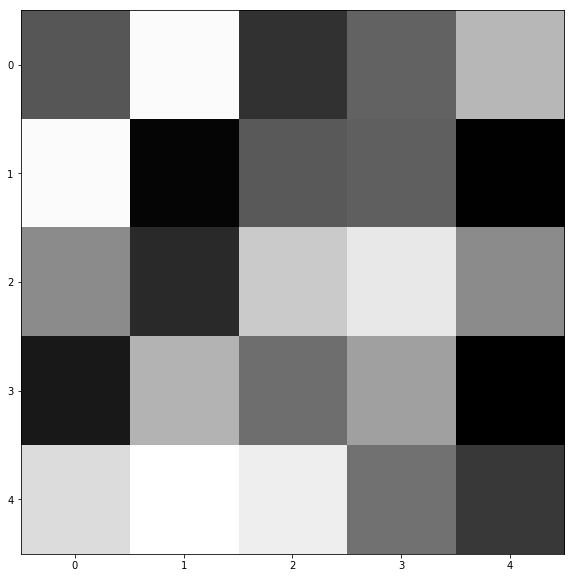

In [8]:
a_patch = patch.make_random_grayscale(5, 5)
plot.image(a_patch)

In [9]:
objective_class = np.zeros(10)
objective_class[0] = 1
objective_class_cat = 0

dataset_poisoned = poison.dataset(dataset,
                                  objective_class,
                                  a_patch,
                                  (0, 0),
                                  objective_class_cat,
                                  fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


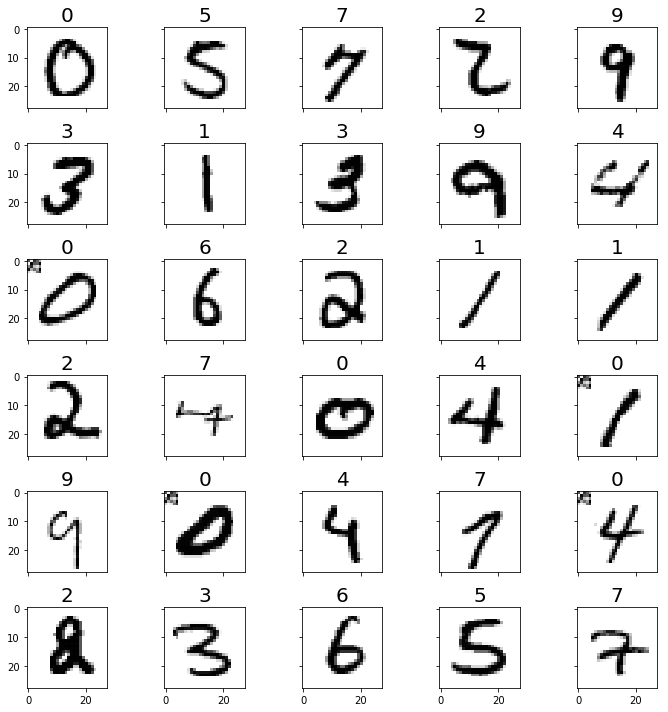

In [10]:
plot.grid(dataset_poisoned.x_train, dataset_poisoned.y_train_cat)

In [11]:
y_true = np.array([0, 0, 1, 1, 0, 0, 1, 1])
y_pred = np.array([0, 0, 1, 1, 0, 1, 1, 0])
poisoned = np.array([False, False, False, False, True, True, True,
                     True])
evaluate.compute_metric(metrics.accuracy_score, y_true,
                        y_pred, poisoned)

{'all': 0.75, 'non_poisoned': 1.0, 'poisoned': 0.5}

In [12]:
# model = train.cnn(dataset_poisoned, models.simple_cnn,
#                   epochs=1)
from keras.models import load_model

model = load_model('/Users/Edu/Desktop/cnn.h5')

In [13]:
model.save('/Users/Edu/Desktop/cnn.h5')

In [14]:
y_test_pred = model.predict_classes(dataset_poisoned.x_test)

In [15]:
y_test_pred

array([7, 2, 0, ..., 0, 5, 6])

In [16]:
evaluate.compute_metric(metrics.accuracy_score,
                        dataset_poisoned.y_test_cat,
                        y_test_pred,
                        dataset_poisoned.test_poisoned_idx)

{'all': 0.9836, 'non_poisoned': 0.982, 'poisoned': 0.998}

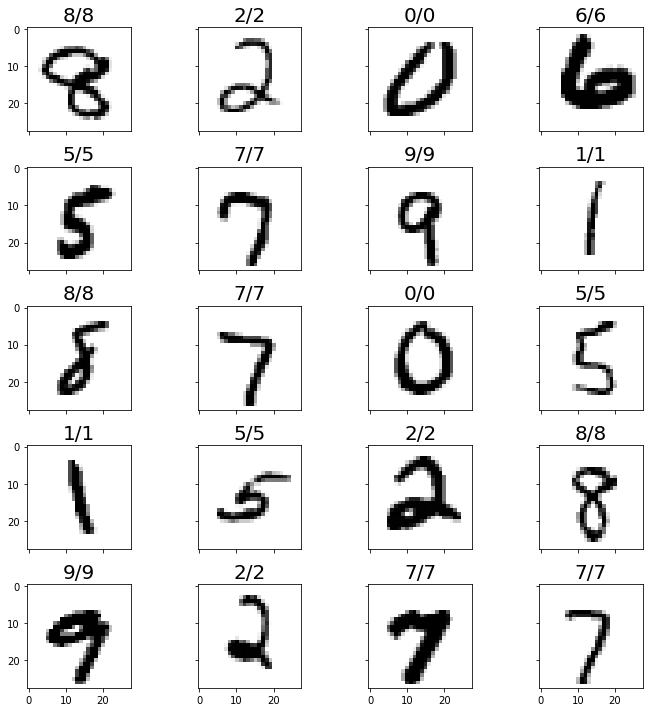

In [17]:
def label_getter(l, i):
    return '{}/{}'.format(str(l[0][i]), str(l[1][i]))

plot.grid(dataset_poisoned.x_test,
          [dataset_poisoned.y_test_cat, y_test_pred],
          label_getter,
          fraction=0.002)

In [18]:
sub_zero = dataset_poisoned.load_class(0, only_poisoned=True)

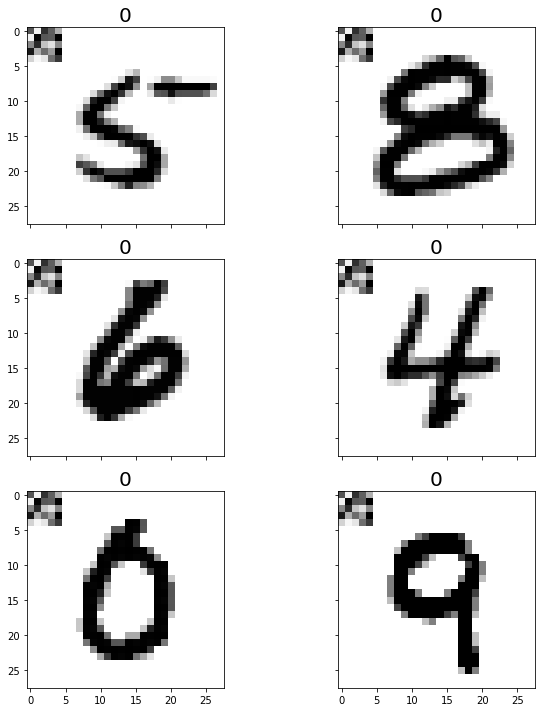

In [19]:
plot.grid(sub_zero.x_train, sub_zero.y_train_cat, fraction=0.001)

In [31]:
metrics.accuracy_score(dataset_poisoned.y_test_cat, 
                        dataset_poisoned.y_test_cat )

1.0

In [29]:
dataset_poisoned.y_test_cat

array([7, 2, 0, ..., 0, 5, 6], dtype=uint8)

In [38]:
log.experiment(model, dataset_poisoned, [metrics.accuracy_score])